In [1]:
import pandas as pd
import glob
import os

In [2]:
cd ../sourmash/maca/facs_compute_v7_all/

/home/olga/code/kmer-hashing/sourmash/maca/facs_compute_v7_all


In [3]:
import re

In [128]:
MEAN_MAX_PATTERN = r'mean=(\d+\.?\d*) max=(\d+\.?\d*)'

profile_stats = ['mean', 'max']

features = ['cpu', 'mem' ]#'disk', 'tmp']
feature_units = ['', '[MBK]iB', '[MBK]', '[MBK]']

feature_patterns = {}
for feature, unit in zip(features, feature_units):
    suffix = ' '.join(f'{stat}=(\d+\.?\d*{unit})' for stat in profile_stats)
    pattern = f'{feature} {suffix}'
    feature_patterns[feature] = pattern

time_pattern = 'time=(\d+)m(\d+)s'
feature_patterns['time'] = time_pattern
# prefix_patterns = {prefix: prefix + ' ' + MEAN_MAX_PATTERN 
#                    for feature, unit in zip(features, feature_units)}
# prefix_patterns['mem'] = r'mem mean=(\d+\.\d+)[MBK]iB max=(\d+\.\d+)[MBK]iB'
feature_patterns

{'cpu': 'cpu mean=(\\d+\\.?\\d*) max=(\\d+\\.?\\d*)',
 'mem': 'mem mean=(\\d+\\.?\\d*[MBK]iB) max=(\\d+\\.?\\d*[MBK]iB)',
 'time': 'time=(\\d+)m(\\d+)s'}

In [129]:
time_pattern = 'time=(\d+)m(\d+)s'

In [130]:
re.findall(prefix_patterns['mem'],  'mem mean=17.6MiB max=18.1MiB')

[('17.6', '18.1')]

In [131]:
re.findall(prefix_patterns['disk'], 'disk mean=0B max=0B')

[('0', '0')]

In [132]:
re.findall(prefix_patterns['cpu'],  'cpu mean=1.0 max=1.0')

[('1.0', '1.0')]

In [133]:
re.findall('time=(\d+)m(\d+)s', '2018/08/16 03:14:01 total n=5 time=4m4s')

[('4', '4')]

In [134]:
feature_stats = {k: ('mean', 'max') for k in features}
feature_stats['time'] = ('min', 'sec')
feature_stats

{'cpu': ('mean', 'max'), 'mem': ('mean', 'max'), 'time': ('min', 'sec')}

In [135]:
import bitmath

mem_mean = bitmath.parse_string('17.6MiB')

In [136]:
mem_mean

MiB(17.6)

In [137]:
mem_mean.to_Gb()

Gb(0.14763950080000002)

In [138]:
mem_mean.to_GB()

GB(0.018454937600000002)

In [139]:
mem_mean.to_GiB()

GiB(0.0171875)

In [140]:
mem_mean.to_MiB()

MiB(17.6)

In [141]:
mem_mean.value

17.6

In [142]:
mem_mean_Gib = mem_mean.to_Gib()


In [146]:


data = []
 
def add_data(sample_id, feature, stat, value, d):
    value = float(value)
    d = dict(sample_id=sample_id, feature=feature, stat=stat, value=value)
    data.append(d)
    
    
def parse_values(found):
    """Convert string values into addable floats"""
    try:
        # Simple conversion to floats - no other strings
        found = [float(x) for x in found[0]]
    except ValueError:
        # There's letters in here specifying the unit
        found = [bitmath.parse_string(x).to_MiB() for x in found[0]]
    return found


# def maybe_add_data_from_line()


for filename in glob.iglob('log*'):
    basename = os.path.basename(filename)
    sample_id = basename.split('log.')[-1]
    with open(filename) as f:
        for line in f:
            for feature, pattern in feature_patterns.items():
                found = re.findall(pattern, line)
                if len(found) > 0:
                    
                    stats = feature_stats[feature]
                    
                    found = parse_values(found)
                        
                    if feature == 'time':
                        stat = 'seconds'
                        # first field is minutes, second is seconds. save total seconds
                        value = found[0]*60 + found[1]
                        add_data(sample_id, feature, stat, value, d)
                        continue
                    
                    for stat, value in zip(stats, found):
                        add_data(sample_id, feature, stat, value, d)


profile = pd.DataFrame(data)
# profile['value'] = profile['value'].astype(float)
print(profile.shape)
profile.head()

(284324, 4)


,feature,sample_id,stat,value
0,cpu,P11-B001717-3_38_F-1-1,mean,0.9
1,cpu,P11-B001717-3_38_F-1-1,max,1.0
2,cpu,P19-MAA000556-3_9_M-1-1,mean,0.7
3,cpu,P19-MAA000556-3_9_M-1-1,max,1.0
4,cpu,P19-MAA000556-3_9_M-1-1,mean,0.7


In [147]:
profile.groupby(['feature', 'stat']).describe()

value                                                     \
                   count        mean         std   min    25%    50%    75%   
feature stat                                                                  
cpu     max      85531.0    1.162398    1.191359   0.0    1.0    1.0    1.0   
        mean     85531.0    1.099200    1.129704   0.0    0.9    1.0    1.0   
mem     max      39225.0   23.950886   62.629606   1.5   17.8   18.2   18.5   
        mean     39225.0   21.543131   50.540739   1.5   17.4   17.6   17.9   
time    seconds  34812.0  312.809376  165.413489  60.0  204.0  288.0  384.0   

                         
                    max  
feature stat             
cpu     max        10.1  
        mean        7.9  
mem     max      1021.4  
        mean     1021.4  
time    seconds  1875.0

In [148]:
profile_mem_cpu.groupby(['feature', 'stat']).describe()

value                                                     
                count       mean        std  min   25%   50%   75%     max
feature stat                                                              
cpu     max   85428.0   1.162018   1.190453  0.0   1.0   1.0   1.0    10.1
        mean  85428.0   1.098815   1.128797  0.0   0.9   1.0   1.0     7.9
mem     max   39167.0  23.959147  62.675589  1.5  17.8  18.2  18.5  1021.4
        mean  39167.0  21.548903  50.577920  1.5  17.4  17.6  17.9  1021.4

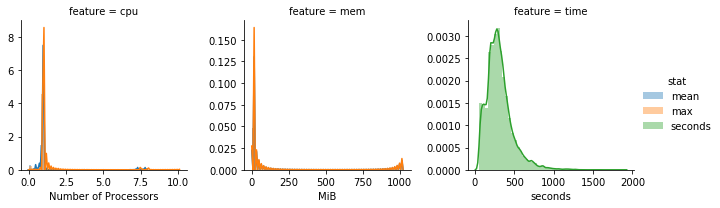

In [158]:
import seaborn as sns

g = sns.FacetGrid(profile, col='feature', hue='stat', 
                  sharex=False, sharey=False, col_wrap=3)
g.map(sns.distplot, 'value')
for ax in g.axes.flat:
    if 'time' in ax.get_title():
        xlabel = 'Seconds'
    elif 'mem' in ax.get_title():
        xlabel = 'MiB'
    else:
        xlabel = 'Number of Processors'
    ax.set(xlabel=xlabel)
g.add_legend()

Disk and tmp are zero for everything - remove

In [150]:
disk_tmp = "disk", "tmp"

profile_not_disk_tmp = profile.query("feature not in @disk_tmp")
profile_not_disk_tmp.head()

,feature,sample_id,stat,value
0,cpu,P11-B001717-3_38_F-1-1,mean,0.9
1,cpu,P11-B001717-3_38_F-1-1,max,1.0
2,cpu,P19-MAA000556-3_9_M-1-1,mean,0.7
3,cpu,P19-MAA000556-3_9_M-1-1,max,1.0
4,cpu,P19-MAA000556-3_9_M-1-1,mean,0.7


In [151]:
profile_time = profile_not_disk_tmp.query("feature == 'time'")
profile_time.head()

,feature,sample_id,stat,value
8,time,P19-MAA000556-3_9_M-1-1,seconds,193.0
21,time,P6-D042186-3_8_M-1-1,seconds,233.0
40,time,I17-MAA000906-3_11_M-1-1,seconds,240.0
53,time,N8-MAA000526-3_9_M-1-1,seconds,393.0
60,time,I1-B002433-3_38_F-1-1,seconds,343.0


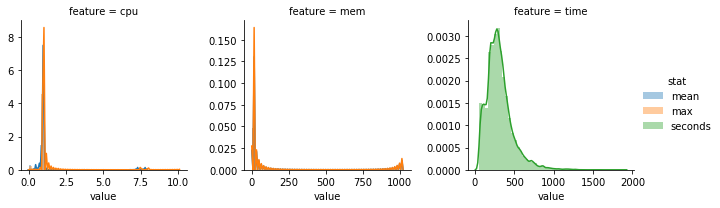

In [152]:
import seaborn as sns

g = sns.FacetGrid(profile_not_disk_tmp, col='feature', hue='stat', 
                  sharex=False, sharey=False, col_wrap=3)
g.map(sns.distplot, 'value')
g.add_legend()

In [153]:
mem_cpu = "mem", "cpu"

profile_mem_cpu = profile.query("feature in @mem_cpu")
profile_mem_cpu.head()

,feature,sample_id,stat,value
0,cpu,P11-B001717-3_38_F-1-1,mean,0.9
1,cpu,P11-B001717-3_38_F-1-1,max,1.0
2,cpu,P19-MAA000556-3_9_M-1-1,mean,0.7
3,cpu,P19-MAA000556-3_9_M-1-1,max,1.0
4,cpu,P19-MAA000556-3_9_M-1-1,mean,0.7


/home/olga/miniconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


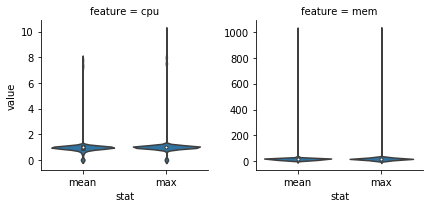

In [154]:
g = sns.FacetGrid(profile_mem_cpu, col='feature', sharex=False, sharey=False)
g.map(sns.violinplot, 'stat', 'value', split=True)
g.add_legend()

In [155]:
profile_time['minutes'] = profile_time['value']/60
profile_time.head()

/home/olga/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,feature,sample_id,stat,value,minutes
8,time,P19-MAA000556-3_9_M-1-1,seconds,193.0,3.216667
21,time,P6-D042186-3_8_M-1-1,seconds,233.0,3.883333
40,time,I17-MAA000906-3_11_M-1-1,seconds,240.0,4.000000
53,time,N8-MAA000526-3_9_M-1-1,seconds,393.0,6.550000
60,time,I1-B002433-3_38_F-1-1,seconds,343.0,5.716667


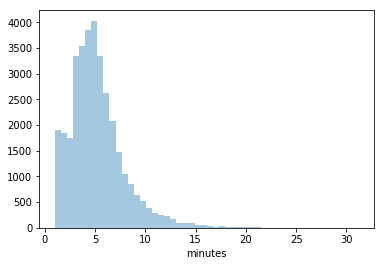

In [156]:
sns.distplot(profile_time['minutes'], kde=False)